In [1]:
# Solving the committor equation via neural network representation
import numpy as np
import math
import csv
import matplotlib.pyplot as plt
import torch
import torch.nn as nn

In [2]:
def M_fun(x1,x2):
    M11 = 40000*(1+15*x1)**(-2)
    M12 = np.zeros_like(x1)
    M22 = 40000*(1+15*x2)**(-2)
    return M11, M12, M22

def M_fun_torch(x1,x2):
    #x1_torch = torch.from_numpy(x1)
    #x2_torch = torch.from_numpy(x2)
    x1_torch = x1
    x2_torch = x2

    M11 = 40000*(1+15*x1_torch)**(-2)
    M12 = torch.zeros_like(x1_torch)
    M22 = 40000*(1+15*x2_torch)**(-2)
    return M11, M12, M22

def M_fun_inv_torch(x1,x2):
    M11, M12, M22 = M_fun_torch(x1,x2)
    J = M11*M22 - M12**2
    M11_inv = M22/J
    M12_inv = -M12/J
    M22_inv = M11/J
    return M11_inv, M12_inv, M22_inv

In [3]:
X1 = np.loadtxt('x1.csv', delimiter=',')
X2 = np.loadtxt('x2.csv', delimiter=',')
Nx1, Nx2 = np.shape(X1)

south_np = np.concatenate((X1[0:1,:], X2[0:1,:]), axis=0).T
north_np = np.concatenate((X1[-1:Nx2,:], X2[-1:Nx2,:]), axis=0).T
west_np = np.concatenate((X1[:,0:1], X2[:,0:1]), axis=1)
east_np = np.concatenate((X1[:,-1:Nx1], X2[:,-1:Nx1]), axis=1)

<function matplotlib.pyplot.show(close=None, block=None)>

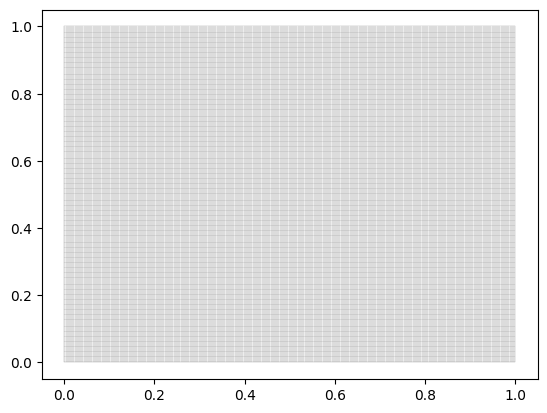

In [4]:
plt.plot(X1, X2, 'k', linewidth=0.1)
plt.plot(X1.T, X2.T, 'k', linewidth=0.1)
plt.show

In [146]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
dtype = torch.float32

def to_xy_tensor(arr, N=None):
    # arr can be shape (2*N,) or (N,2)
    a = np.asarray(arr)
    if a.ndim == 1:
        assert N is not None, "Need N to reshape a flat (2*N,) boundary array"
        a = a.reshape(N, 2)
    assert a.shape[1] == 2
    return torch.as_tensor(a, device=device, dtype=dtype)

south_xy = to_xy_tensor(south_np, N=Nx1)
north_xy = to_xy_tensor(north_np, N=Nx1)
west_xy  = to_xy_tensor(west_np,  N=Nx2)
east_xy  = to_xy_tensor(east_np,  N=Nx2)

def polyline_normals(xy, interior_point):
    """
    xy: (Nb,2) ordered points along a boundary polyline (open).
    returns n_hat: (Nb,2) outward unit normals, oriented using interior_point.
    """
    # neighbor differences (central-ish)
    d = torch.zeros_like(xy)
    d[1:-1] = xy[2:] - xy[:-2]
    d[0]    = xy[1] - xy[0]
    d[-1]   = xy[-1] - xy[-2]

    # tangent
    t = d / (d.norm(dim=1, keepdim=True) + 1e-12)

    # normal candidates (rotate tangent by +90 deg): (tx,ty) -> (ty,-tx)
    n = torch.stack([t[:,1], -t[:,0]], dim=1)

    # orient outward: want n · (interior - p) < 0 (pointing away from interior)
    v = (interior_point[None,:] - xy)  # from boundary point to interior
    flip = (n * v).sum(dim=1, keepdim=True) > 0
    n = torch.where(flip, -n, n)

    # normalize
    n_hat = n / (n.norm(dim=1, keepdim=True) + 1e-12)
    return n_hat

all_bdry = torch.cat([south_xy, north_xy, west_xy, east_xy], dim=0)
interior = all_bdry.mean(dim=0)
n_south = polyline_normals(south_xy, interior)
n_north = polyline_normals(north_xy, interior)
n_west  = polyline_normals(west_xy,  interior)
n_east  = polyline_normals(east_xy,  interior)

# Randomly sample boundary minibatches each iteration
def sample_boundary(xy, n_hat, Nb):
    idx = torch.randint(0, xy.shape[0], (Nb,), device=xy.device)
    return xy[idx], n_hat[idx]

# Autodiff helpers for Neumann terms
def grad_wrt_xy(scalar, xy):
    # scalar: (N,1), xy: (N,2) with requires_grad=True
    g = torch.autograd.grad(
        outputs=scalar.sum(),
        inputs=xy,
        create_graph=True,
        retain_graph=True
    )[0]
    return g  # (N,2) = [d/dx, d/dy]

def normal_derivative(scalar, xy, n_hat):
    g = grad_wrt_xy(scalar, xy)                # (N,2)
    return (g * n_hat).sum(dim=1, keepdim=True)  # (N,1)

# Boundary loss wiring (Dirichlet + Neumann conditions)
def boundary_loss(net, Nb=256, w_dir=10.0, w_neu=1.0):
    # sample each side
    xyS, nS = sample_boundary(south_xy, n_south, Nb)
    xyN, nN = sample_boundary(north_xy, n_north, Nb)
    xyW, nW = sample_boundary(west_xy,  n_west,  Nb)
    xyE, nE = sample_boundary(east_xy,  n_east,  Nb)

    # require grads for Neumann
    xyS = xyS.requires_grad_(True)
    xyN = xyN.requires_grad_(True)
    xyW = xyW.requires_grad_(True)
    xyE = xyE.requires_grad_(True)

    # forward: net(xy) -> (xi, eta)
    xiS, etaS = net(xyS).split(1, dim=1)
    xiN, etaN = net(xyN).split(1, dim=1)
    xiW, etaW = net(xyW).split(1, dim=1)
    xiE, etaE = net(xyE).split(1, dim=1)
    #xiS, etaS = xyS.split(1, dim=1)
    #xiN, etaN = xyN.split(1, dim=1)
    #xiW, etaW = xyW.split(1, dim=1)
    #xiE, etaE = xyE.split(1, dim=1)

    # Dirichlet soft losses
    L_dir = (
        torch.nn.functional.mse_loss(etaS, torch.zeros_like(etaS)) +   # south: eta=0
        torch.nn.functional.mse_loss(etaN, torch.ones_like(etaN))  +   # north: eta=1
        torch.nn.functional.mse_loss(xiW,  torch.zeros_like(xiW))  +   # west:  xi=0
        torch.nn.functional.mse_loss(xiE,  torch.ones_like(xiE))       # east:  xi=1
    )

    # Neumann soft losses
    # south/north: dxi/dn = 0
    dxi_dn_S = normal_derivative(xiS, xyS, nS)
    dxi_dn_N = normal_derivative(xiN, xyN, nN)
    # west/east: deta/dn = 0
    deta_dn_W = normal_derivative(etaW, xyW, nW)
    deta_dn_E = normal_derivative(etaE, xyE, nE)

    L_neu = (
        (dxi_dn_S**2).mean() +
        (dxi_dn_N**2).mean() +
        (deta_dn_W**2).mean() +
        (deta_dn_E**2).mean()
    )

    return 0*w_dir * L_dir + 1000000*w_neu * L_neu, {"L_dir": L_dir.detach(), "L_neu": L_neu.detach()}


In [138]:
def interior_loss(net, xy_int, Minv_fn,
                          lam_xi=1.0, lam_eta=1.0,
                          eps_det=1e-8,
                          w_det_barrier=1.0, det_target=1e-6):
    """
    Approximates  Σα λα^2 ∫ (∇sα)^T Minv (∇sα) |J| dx
    with uniform/quasi-uniform samples x_k in Ω:
        loss ≈ mean_k [ Σα λα^2 (∇sα)^T Minv (∇sα) |J| ].
    """
    xy = xy_int.requires_grad_(True)         # (N,2)

    s = net(xy)                              # (N,2) = (xi, eta)

    xi  = s[:, 0:1]
    eta = s[:, 1:2]

    g_xi  = grad_wrt_xy(xi,  xy)             # (N,2)
    g_eta = grad_wrt_xy(eta, xy)             # (N,2)

    # detS where S = ds/dx = [[xi_x, xi_y],[eta_x, eta_y]]
    S11, S12 = g_xi[:,0],  g_xi[:,1]
    S21, S22 = g_eta[:,0], g_eta[:,1]
    detS = S11*S22 - S12*S21                 # (N,)

    # |J| = |det(dx/ds)| = 1/|det(ds/dx)|
    #Jabs = 1.0 / (detS.abs() + eps_det)      # (N,)
    detS_pos = detS.clamp_min(eps_det)   # eps_det ~ 1e-8 to 1e-6
    J = 1.0 / detS_pos

    x = xy[:,0]
    y = xy[:,1]
    M11_inv, M12_inv, M22_inv = Minv_fn(x,y)                        # (N,2,2)

    def quadform_from_components(g, M11_inv, M12_inv, M22_inv):
        # g: (N,2)
        gx, gy = g[:, 0], g[:, 1]  # (N,)

        # ensure (N,) (squeeze if (N,1))
        M11 = M11_inv.squeeze(-1)
        M12 = M12_inv.squeeze(-1)
        M22 = M22_inv.squeeze(-1)

        return M11*gx*gx + 2.0*M12*gx*gy + M22*gy*gy

    #q_xi  = quadform_from_components(g_xi, M11_inv, M12_inv, M22_inv)
    #q_eta = quadform_from_components(g_eta, M11_inv, M12_inv, M22_inv)

    q_xi  = quadform_from_components(torch.cat((g_xi[:,0:1],g_eta[:,0:1]),dim=1), M11_inv, M12_inv, M22_inv)
    q_eta = quadform_from_components(torch.cat((g_xi[:,1:2],g_eta[:,1:2]),dim=1), M11_inv, M12_inv, M22_inv)

    integrand = ((lam_xi**2) * q_xi + (lam_eta**2) * q_eta)# * Jabs
    loss = integrand.mean()

    # optional: keep detS positive (orientation-preserving) + not too small
    if w_det_barrier > 0.0:
        #loss = loss + w_det_barrier * torch.nn.functional.softplus(det_target - detS).pow(2).mean()
        #loss = loss + 100*w_det_barrier * torch.nn.functional.softplus(1/detS).pow(2).mean()
        loss = loss + 0.1*w_det_barrier * torch.nn.functional.cross_entropy(1/detS,torch.tensor(1)).mean()

    return loss, {"L_int": loss.detach()}

def orth_loss_forward(Fnet, se, eps=1e-12):
    # se: (N,2) points in computational space (xi,eta)
    se = se.requires_grad_(True)
    X = Fnet(se)                    # (N,2) = (x,y)
    x = X[:, 0:1]
    y = X[:, 1:2]

    # derivatives wrt (xi,eta)
    dx = torch.autograd.grad(x.sum(), se, create_graph=True, retain_graph=True)[0]  # (N,2) = [x_xi, x_eta]
    dy = torch.autograd.grad(y.sum(), se, create_graph=True, retain_graph=True)[0]  # (N,2) = [y_xi, y_eta]

    F_xi  = torch.cat([dx[:,0:1], dy[:,0:1]], dim=1)  # (N,2)
    F_eta = torch.cat([dx[:,1:2], dy[:,1:2]], dim=1)  # (N,2)

    g12 = (F_xi * F_eta).sum(dim=1)                   # (N,)
    g11 = (F_xi * F_xi).sum(dim=1)                    # (N,)
    g22 = (F_eta * F_eta).sum(dim=1)                  # (N,)

    return (g12*g12 / (g11*g22 + eps)).mean()


In [140]:
def train(net,
          steps=50,
          N_int=4096,
          N_bdry=256,
          lr=2e-4,
          lam_xi=1.0, lam_eta=1.0,
          w_dir=10.0, w_neu=1.0,
          w_det_init=0.1, w_det_final=10.0,
          det_target_init=1e-10, det_target_final=1e-6,
          grad_clip=1.0,
          log_every=1):

    net.to(device=device, dtype=dtype)
    opt = torch.optim.Adam(net.parameters(), lr=lr)

    best = {"loss": float("inf"), "state": None}

    for step in range(1, steps+1):
        # ---- continuation schedules (linear ramps) ----
        #t = step / steps
        #w_det = w_det_init + (w_det_final - w_det_init) * t
        #det_target = det_target_init + (det_target_final - det_target_init) * t

        # ---- sample interior (quasi-uniform in Ω) ----
        #xy_int = sample_interior(N_int).to(device=device, dtype=dtype)  # (N,2)
        xy_int = np.concatenate((X1.flatten().reshape(-1, 1), X2.flatten().reshape(-1, 1)), axis=1)
        xy_int = torch.from_numpy(xy_int).float()

        # ---- compute losses ----
        L_int, stats_int = interior_loss(
            net, xy_int, M_fun_torch,#M_fun_inv_torch,
            lam_xi=lam_xi, lam_eta=lam_eta
        )

        L_bdry, stats_bdry = boundary_loss(
            net, Nb=N_bdry, w_dir=w_dir, w_neu=w_neu
        )

        loss = L_int + L_bdry

        # Boundary monotonicity enforcement
        xyS = np.concatenate((X1[0:1,:].flatten().reshape(-1, 1), X2[0:1,:].flatten().reshape(-1, 1)), axis=1)
        xyN = np.concatenate((X1[99:100,:].flatten().reshape(-1, 1), X2[99:100,:].flatten().reshape(-1, 1)), axis=1)
        xyW = np.concatenate((X1[:,0:1].flatten().reshape(-1, 1), X2[:,0:1].flatten().reshape(-1, 1)), axis=1)
        xyE = np.concatenate((X1[:,99:100].flatten().reshape(-1, 1), X2[:,99:100].flatten().reshape(-1, 1)), axis=1)
        xyS = torch.from_numpy(xyS).float().requires_grad_(True)
        xyN = torch.from_numpy(xyN).float().requires_grad_(True)
        xyW = torch.from_numpy(xyW).float().requires_grad_(True)
        xyE = torch.from_numpy(xyE).float().requires_grad_(True)

        xiS = net(xyS)[:,0:1]
        xiN = net(xyN)[:,0:1]
        etaW = net(xyW)[:,1:2]
        etaE = net(xyE)[:,1:2]
        mono_eps = torch.tensor(0.00001)

        d_xi_dx_S = torch.autograd.grad(xiS.sum(), xyS, create_graph=True)[0][:,0:1]
        d_xi_dx_N = torch.autograd.grad(xiN.sum(), xyN, create_graph=True)[0][:,0:1]
        d_eta_dy_W = torch.autograd.grad(etaW.sum(), xyW, create_graph=True)[0][:,1:2]
        d_eta_dy_E = torch.autograd.grad(etaE.sum(), xyE, create_graph=True)[0][:,1:2]

        L_mono = (
          torch.nn.functional.softplus(mono_eps - d_xi_dx_S).pow(2).mean() +
          torch.nn.functional.softplus(mono_eps - d_xi_dx_N).pow(2).mean() +
          torch.nn.functional.softplus(mono_eps - d_eta_dy_W).pow(2).mean() +
          torch.nn.functional.softplus(mono_eps - d_eta_dy_E).pow(2).mean()
        )
        loss = loss + 0*L_mono
        # ---------------------------------

        # Orthogonalization promoting loss part
        w_orth = 1.0  # start small, ramp up later
        L_orth = orth_loss_forward(net, xy_int)   # or orth_loss_forward
        loss = loss + w_orth*L_orth

        # ---- step ----
        opt.zero_grad(set_to_none=True)
        loss.backward()

        #if grad_clip is not None:
        #    torch.nn.utils.clip_grad_norm_(net.parameters(), grad_clip)

        opt.step()

        # ---- track best (you may want to include detS_min>0 condition) ----
        if loss.item() < best["loss"]:
            best["loss"] = loss.item()
            best["state"] = {k: v.detach().cpu().clone() for k, v in net.state_dict().items()}

        # ---- logging ----
        if step % log_every == 0:
            print(
                f"step {step:6d} | "
                f"loss {loss.item():.4e} | "
                f"Lint {stats_int['L_int'].item():.3e} "
                #f"Ldet {stats_int['L_det'].item():.3e} "
                f"Lbdry {(L_bdry.detach()).item():.3e} | "
                #f"detS min {stats_int['detS_min'].item():.3e} mean {stats_int['detS_mean'].item():.3e} | "
                #f"w_det {w_det:.2e} det_target {det_target:.1e}"
            )

    # restore best weights
    if best["state"] is not None:
        net.load_state_dict(best["state"])
    return net, best


In [62]:
class Model(nn.Module):
    """
    Residual network R_theta: (x,y) -> (Δxi, Δη), i.e. 2 outputs.
    Use with CombinedNet so full map is:
        s(x,y) = (x,y) + g(x,y) * R_theta(x,y)
    """
    def __init__(self, width=128, depth=4, act=nn.Tanh()):
        super().__init__()
        layers = []
        in_dim, out_dim = 2, 2

        dims = [in_dim] + [width]*depth + [out_dim]
        for a, b in zip(dims[:-1], dims[1:]):
            layers.append(nn.Linear(a, b))
            if b != out_dim:
                layers.append(act)

        self.net = nn.Sequential(*layers)

        # optional: make initial output exactly zero so CombinedNet starts at uniform guess
        #for m in self.net.modules():
        #    if isinstance(m, nn.Linear):
        #        nn.init.zeros_(m.weight)
        #        nn.init.zeros_(m.bias)

    def forward(self, xy: torch.Tensor) -> torch.Tensor:
        x = xy[:, 0:1]
        y = xy[:, 1:2]
        dirichlet1 = x*(1.0-x)
        dirichlet2 = y*(1.0-y)
        return torch.cat((x + dirichlet1 * self.net(xy)[:,0:1], y + dirichlet2 * self.net(xy)[:,1:2]), dim=1)  # (N,2) = (Δxi, Δη)

In [21]:
net = Model()
# After building your residual net
for m in net.modules():
    if isinstance(m, nn.Linear):
        nn.init.xavier_uniform_(m.weight)
        nn.init.zeros_(m.bias)

# zero ONLY the last Linear layer so residual starts at 0 but is trainable
last = [m for m in net.modules() if isinstance(m, nn.Linear)][-1]
nn.init.zeros_(last.weight)
nn.init.zeros_(last.bias)

Parameter containing:
tensor([0., 0.], requires_grad=True)

In [9]:
# after loss.backward()
for name,p in net.named_parameters():
    if p.grad is not None:
        print(name, p.grad.abs().mean().item())

In [147]:
net = Model()
train(net)

step      1 | loss 5.3050e+03 | Lint 5.007e+03 Lbdry 2.975e+02 | 
step      2 | loss 4.9039e+03 | Lint 4.804e+03 Lbdry 9.961e+01 | 
step      3 | loss 4.6153e+03 | Lint 4.600e+03 Lbdry 1.535e+01 | 
step      4 | loss 4.4132e+03 | Lint 4.397e+03 Lbdry 1.620e+01 | 
step      5 | loss 4.2605e+03 | Lint 4.200e+03 Lbdry 6.097e+01 | 
step      6 | loss 4.1261e+03 | Lint 4.011e+03 Lbdry 1.146e+02 | 
step      7 | loss 3.9996e+03 | Lint 3.835e+03 Lbdry 1.648e+02 | 
step      8 | loss 3.8368e+03 | Lint 3.670e+03 Lbdry 1.664e+02 | 
step      9 | loss 3.6917e+03 | Lint 3.516e+03 Lbdry 1.762e+02 | 
step     10 | loss 3.5226e+03 | Lint 3.369e+03 Lbdry 1.534e+02 | 
step     11 | loss 3.3568e+03 | Lint 3.229e+03 Lbdry 1.282e+02 | 
step     12 | loss 3.2118e+03 | Lint 3.092e+03 Lbdry 1.203e+02 | 
step     13 | loss 3.0627e+03 | Lint 2.956e+03 Lbdry 1.063e+02 | 
step     14 | loss 2.9436e+03 | Lint 2.821e+03 Lbdry 1.226e+02 | 
step     15 | loss 2.8169e+03 | Lint 2.685e+03 Lbdry 1.315e+02 | 
step     1

(Model(
   (net): Sequential(
     (0): Linear(in_features=2, out_features=128, bias=True)
     (1): Tanh()
     (2): Linear(in_features=128, out_features=128, bias=True)
     (3): Tanh()
     (4): Linear(in_features=128, out_features=128, bias=True)
     (5): Tanh()
     (6): Linear(in_features=128, out_features=128, bias=True)
     (7): Tanh()
     (8): Linear(in_features=128, out_features=2, bias=True)
   )
 ),
 {'loss': 1140.4315185546875,
  'state': {'net.0.weight': tensor([[-0.1207, -0.5622],
           [ 0.0394, -0.2732],
           [ 0.6083, -0.4314],
           [ 0.4498,  0.5837],
           [-0.3273, -0.3052],
           [ 0.3991, -0.2229],
           [-0.2827,  0.4011],
           [-0.4900,  0.0586],
           [-0.0564, -0.2785],
           [ 0.1204,  0.2641],
           [-0.2841,  0.0099],
           [ 0.1505,  0.5715],
           [-0.4862, -0.2706],
           [-0.2660,  0.6086],
           [-0.2232, -0.3685],
           [-0.4785, -0.4862],
           [-0.2737,  0.4071],


In [57]:
xy_int = np.concatenate((X1.flatten().reshape(-1, 1), X2.flatten().reshape(-1, 1)), axis=1)
xy_int = torch.from_numpy(xy_int).float()
net(xy_int)

tensor([[ 0.0000e+00,  0.0000e+00],
        [-4.6201e-05,  0.0000e+00],
        [-4.6609e-05,  0.0000e+00],
        ...,
        [ 9.7760e-01,  1.0000e+00],
        [ 9.8877e-01,  1.0000e+00],
        [ 1.0000e+00,  1.0000e+00]], grad_fn=<CatBackward0>)

In [148]:
X = torch.reshape(net(xy_int)[:,0], (Nx2,Nx1)).detach().numpy()
Y = torch.reshape(net(xy_int)[:,1], (Nx2,Nx1)).detach().numpy()

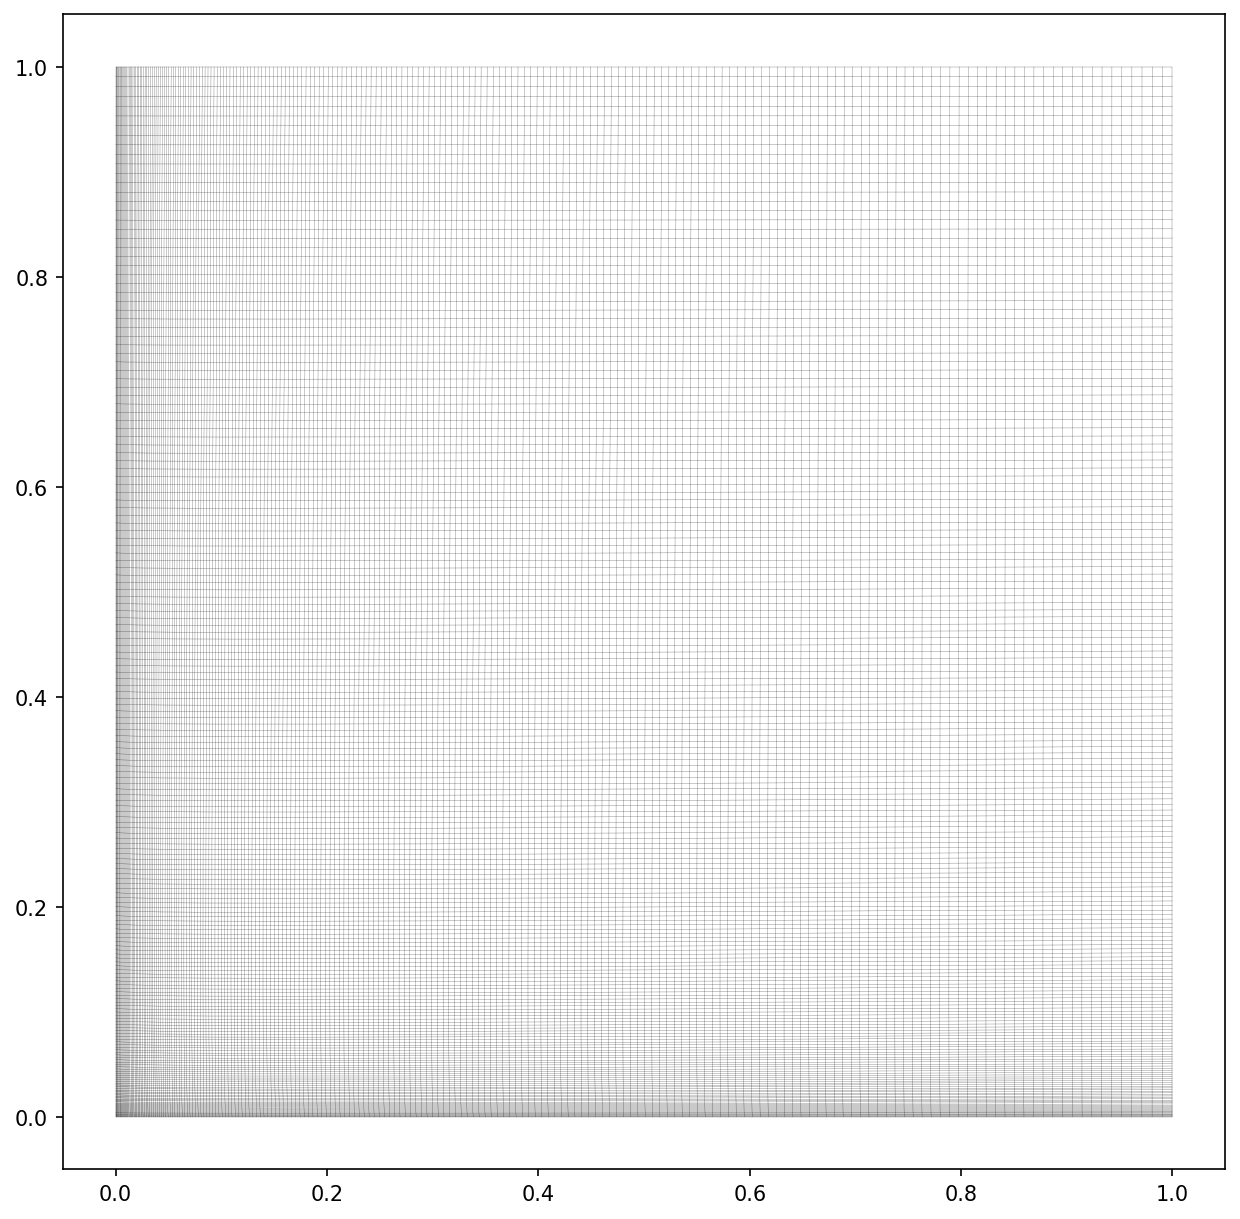

In [149]:
fig, ax = plt.subplots(figsize=(10, 10), dpi=150)
ax.plot(X, Y, 'k', linewidth=0.1)
ax.plot(X.T, Y.T, 'k', linewidth=0.1)
plt.show()